# Evaluate Dst forecasts

> The baseline is the benchmark by Licata et. al.

In [2]:
# Imports
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices() # fix to make the script work in the MIT supercloud
from swdf.benchmark import *
from tsai.basics import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
wandb_api = wandb.Api()

In [4]:
# Constants
ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/solfsmy_eval_tmp"

In [5]:
# Config
config = yaml2dict('config/dst.yaml')
config = config.eval
config

```json
{ 'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'}
```

In [6]:
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)
learn = load_learner_all('tmp', verbose=True, device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [7]:
y_test_preds, y_test = learn.get_preds(ds_idx = 2, with_targs=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (45888, 1, 144)


In [9]:
horizon = y_test.shape[-1]
horizon_days = int(np.ceil(horizon / 24))
data_columns_fcst = ['DST']
horizon, horizon_days

(144, 6)

The threshold classify the forecasts of Dst are based on the values of the Dst itself
and the solar activity level, as defined by the F10.7 (according to Licata et al.).
Therefore, below is the table of all possible combined conditions to evaluate Dst.

| Dst Level | Solar Level | Dst Value         | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| G0        | Low         | Dst ≥ -30         | F 10.7 ≤ 75       |
| G0        | Moderate    | Dst ≥ -30         | 75 < F 10.7 ≤ 150 |
| G0        | Elevated    | Dst ≥ -30         | 150 < F 10.7 ≤ 190|
| G0        | High        | Dst ≥ -30         | F 10.7 > 190      |
| G1        | Low         | -30 > Dst ≥ -50   | F 10.7 ≤ 75       |
| G1        | Moderate    | -30 > Dst ≥ -50   | 75 < F 10.7 ≤ 150 |
| G1        | Elevated    | -30 > Dst ≥ -50   | 150 < F 10.7 ≤ 190|
| G1        | High        | -30 > Dst ≥ -50   | F 10.7 > 190      |
| G2        | Low         | -50 > Dst ≥ -90   | F 10.7 ≤ 75       |
| G2        | Moderate    | -50 > Dst ≥ -90   | 75 < F 10.7 ≤ 150 |
| G2        | Elevated    | -50 > Dst ≥ -90   | 150 < F 10.7 ≤ 190|
| G2        | High        | -50 > Dst ≥ -90   | F 10.7 > 190      |
| G3        | Low         | -90 > Dst ≥ -130  | F 10.7 ≤ 75       |
| G3        | Moderate    | -90 > Dst ≥ -130  | 75 < F 10.7 ≤ 150 |
| G3        | Elevated    | -90 > Dst ≥ -130  | 150 < F 10.7 ≤ 190|
| G3        | High        | -90 > Dst ≥ -130  | F 10.7 > 190      |
| G4        | Low         | -130 > Dst ≥ -350 | F 10.7 ≤ 75       |
| G4        | Moderate    | -130 > Dst ≥ -350 | 75 < F 10.7 ≤ 150 |
| G4        | Elevated    | -130 > Dst ≥ -350 | 150 < F 10.7 ≤ 190|
| G4        | High        | -130 > Dst ≥ -350 | F 10.7 > 190      |
| G5        | Low         | Dst ≤ -350        | F 10.7 ≤ 75       |
| G5        | Moderate    | Dst ≤ -350        | 75 < F 10.7 ≤ 150 |
| G5        | Elevated    | Dst ≤ -350        | 150 < F 10.7 ≤ 190|
| G5        | High        | Dst ≤ -350        | F 10.7 > 190      |


In order to create all those combined conditions, let's merge the data from Dst
and F10.7. Since this data is provided with different frequencies (1 day for F10.7 
and 1 hour for Dst, we will fill the missing timestamps of F10.7 with forward-filling)


In [10]:
# We'll load again the data from Dst with datetimes, and 
# merge the DATE and TIME columns into a single datetime column
df_dst_raw = pd.read_csv(config.dst_data_path, sep='\s{2,}|\s', 
                         names=['DATE', 'TIME', 'DOY', 'DST'])
df_dst_raw['datetime'] = pd.to_datetime(df_dst_raw.DATE + ' ' + df_dst_raw.TIME)

# We need to load the F10.7 data to classify the DST predictions
df_solfsmy = pd.read_csv(config.solfsmy_data_path, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])

# # Convert the JulianDay column to a datetime column
df_solfsmy['datetime'] = pd.to_datetime(df_solfsmy['JulianDay'], unit='D', origin='julian')
# Shift the datetime from 12:00 to 00:00
df_solfsmy['datetime'] = df_solfsmy['datetime'] - pd.Timedelta(hours=12)

# Merge the DST and F10.7 dataframes on the datetime column, and keep only the columns we need
df_combined = pd.merge(df_dst_raw, df_solfsmy, on='datetime', how='left')
df_combined = df_combined[['datetime', 'DST', 'F10']]

# The F10 is given only at 12:00 (00:00 now that we shifted), so we'll forward 
# fill the rest of the values
df_combined['F10'] = df_combined['F10'].fillna(method='ffill')
df_combined.head()

/state/partition1/slurm_tmp/22624332.0.0/ipykernel_57689/1854806815.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_dst_raw = pd.read_csv(config.dst_data_path, sep='\s{2,}|\s',


,datetime,DST,F10
0,1997-01-01 00:00:00,-5.0,72.4
1,1997-01-01 01:00:00,0.0,72.4
2,1997-01-01 02:00:00,3.0,72.4
3,1997-01-01 03:00:00,6.0,72.4
4,1997-01-01 04:00:00,9.0,72.4


In [11]:
#|export

all_possible_dst_conditions = ['G0_Low', 'G0_Moderate', 'G0_Elevated', 'G0_High',
                                 'G1_Low', 'G1_Moderate', 'G1_Elevated', 'G1_High',
                                 'G2_Low', 'G2_Moderate', 'G2_Elevated', 'G2_High',
                                 'G3_Low', 'G3_Moderate', 'G3_Elevated', 'G3_High',
                                 'G4_Low', 'G4_Moderate', 'G4_Elevated', 'G4_High',
                                 'G5_Low', 'G5_Moderate', 'G5_Elevated', 'G5_High',]

def get_dst_condition(dst, f107):
    """
        Function that returns the Dst condition based on the Dst and F10.7 values.
        Input:
        dst: Dst value (float)
        f107: F10.7 value (float)
        Output:
        dst_condition: Dst condition (string)
    """
    if dst >= -30:
        if f107 <= 75:
            dst_condition = 'G0_Low'
        elif f107 <= 150:
            dst_condition = 'G0_Moderate'
        elif f107 <= 190:
            dst_condition = 'G0_Elevated'
        else:
            dst_condition = 'G0_High'
    elif dst >= -50:
        if f107 <= 75:
            dst_condition = 'G1_Low'
        elif f107 <= 150:
            dst_condition = 'G1_Moderate'
        elif f107 <= 190:
            dst_condition = 'G1_Elevated'
        else:
            dst_condition = 'G1_High'
    elif dst >= -90:
        if f107 <= 75:
            dst_condition = 'G2_Low'
        elif f107 <= 150:
            dst_condition = 'G2_Moderate'
        elif f107 <= 190:
            dst_condition = 'G2_Elevated'
        else:
            dst_condition = 'G2_High'
    elif dst >= -130:
        if f107 <= 75:
            dst_condition = 'G3_Low'
        elif f107 <= 150:
            dst_condition = 'G3_Moderate'
        elif f107 <= 190:
            dst_condition = 'G3_Elevated'
        else:
            dst_condition = 'G3_High'
    elif dst >= -350:
        if f107 <= 75:
            dst_condition = 'G4_Low'
        elif f107 <= 150:
            dst_condition = 'G4_Moderate'
        elif f107 <= 190:
            dst_condition = 'G4_Elevated'
        else:
            dst_condition = 'G4_High'
    else:
        if f107 <= 75:
            dst_condition = 'G5_Low'
        elif f107 <= 150:
            dst_condition = 'G5_Moderate'
        elif f107 <= 190:
            dst_condition = 'G5_Elevated'
        else:
            dst_condition = 'G5_High'
    return dst_condition

# Vectorize the get_dst_condition function
get_dst_condition_vec = np.vectorize(get_dst_condition)

In [12]:
# Add the condition column to the dataframe
df_combined["condition"] = get_dst_condition_vec(df_combined["DST"], 
                                                 df_combined["F10"])

In [13]:
X_combined, y_combined = prepare_forecasting_data(df_combined, fcst_history=learn.dls.len, fcst_horizon=learn.dls.d[-1], 
                                x_vars=['DST', 'F10', 'datetime'], 
                                y_vars=['DST', 'F10', 'datetime'])
X_combined.shape, y_combined.shape

((230209, 3, 432), (230209, 3, 144))

In [14]:
#| export

def split_data_by_dst_f107(data):
    """
        function that splits the Dst data into all the possible Dst x F10.7 combinations
        according to the thresholds defined above. # The decision is made based on 
        the timestemp of each sample
        The function returns a dictionary with the Dst x F10.7 combinations as keys
        and the corresponding samples that match the condition as values.
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        data_split: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding Dst data as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result = get_dst_condition_vec(first_timestep_data[:, 0], first_timestep_data[:, 1])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    data_split = {}
    for dst_condition in all_possible_dst_conditions:
        data_split[dst_condition] = data[result == dst_condition]
    return data_split

def get_idxs_per_dst_condition(data):
    """
        Function that returns the indices of the samples that match each 
        Dst x F10.7 condition
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        idxs: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding indices as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result = get_dst_condition_vec(first_timestep_data[:, 0], first_timestep_data[:, 1])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    idxs = {}
    for dst_condition in all_possible_dst_conditions:
        idxs[dst_condition] = np.where(result == dst_condition)[0]
    return idxs

In [15]:
y_combined_train = y_combined[learn.dls[0].splits]
y_combined_valid = y_combined[learn.dls[1].splits]
y_combined_test = y_combined[learn.dls[2].splits]
y_combined_train.shape, y_combined_valid.shape, y_combined_test.shape

((137474, 3, 144), (46129, 3, 144), (45888, 3, 144))

In [16]:
# Splitn y_combined and y_combined_test by Dst x F10.7 combinations
y_combined_train_split = split_data_by_dst_f107(y_combined_train)
y_combined_valid_split = split_data_by_dst_f107(y_combined_valid)
y_combined_test_split = split_data_by_dst_f107(y_combined_test)

# Compare the distributions of the Dst x F10.7 combinations in the training, validation and test sets
print('{:<20} {:<20} {:<20} {}'.format("Condition", "Train", "Valid", "Test"))
for key in all_possible_dst_conditions:
    print('{:<20} {:<20} {:<20} {}'.format(
        key, 
        str(ifnone(y_combined_train_split.get(key),np.array([])).shape),
        str(ifnone(y_combined_valid_split.get(key), np.array([])).shape), 
        str(ifnone(y_combined_test_split.get(key), np.array([])).shape)))

Condition            Train                Valid                Test
G0_Low               (30502, 3, 144)      (24415, 3, 144)      (5667, 3, 144)
G0_Moderate          (66332, 3, 144)      (18035, 3, 144)      (29957, 3, 144)
G0_Elevated          (13836, 3, 144)      (1434, 3, 144)       (4248, 3, 144)
G0_High              (8109, 3, 144)       (232, 3, 144)        (478, 3, 144)
G1_Low               (1127, 3, 144)       (556, 3, 144)        (190, 3, 144)
G1_Moderate          (7511, 3, 144)       (941, 3, 144)        (3240, 3, 144)
G1_Elevated          (2325, 3, 144)       (64, 3, 144)         (544, 3, 144)
G1_High              (1583, 3, 144)       (30, 3, 144)         (74, 3, 144)
G2_Low               (183, 3, 144)        (74, 3, 144)         (24, 3, 144)
G2_Moderate          (2489, 3, 144)       (265, 3, 144)        (1064, 3, 144)
G2_Elevated          (1316, 3, 144)       (14, 3, 144)         (164, 3, 144)
G2_High              (738, 3, 144)        (2, 3, 144)          (0, 3, 144)
G3_Low

In [17]:
# Get the idxs (with respect to the test set) of the samples that match 
# each Dst x F10.7 condition
y_test_split_idxs = get_idxs_per_dst_condition(y_combined_test)
for key, value in y_test_split_idxs.items():
    print(key, value.shape)

G0_Low (5667,)
G0_Moderate (29957,)
G0_Elevated (4248,)
G0_High (478,)
G1_Low (190,)
G1_Moderate (3240,)
G1_Elevated (544,)
G1_High (74,)
G2_Low (24,)
G2_Moderate (1064,)
G2_Elevated (164,)
G2_High (0,)
G3_Low (0,)
G3_Moderate (190,)
G3_Elevated (12,)
G3_High (0,)
G4_Low (0,)
G4_Moderate (36,)
G4_Elevated (0,)
G4_High (0,)
G5_Low (0,)
G5_Moderate (0,)
G5_Elevated (0,)
G5_High (0,)


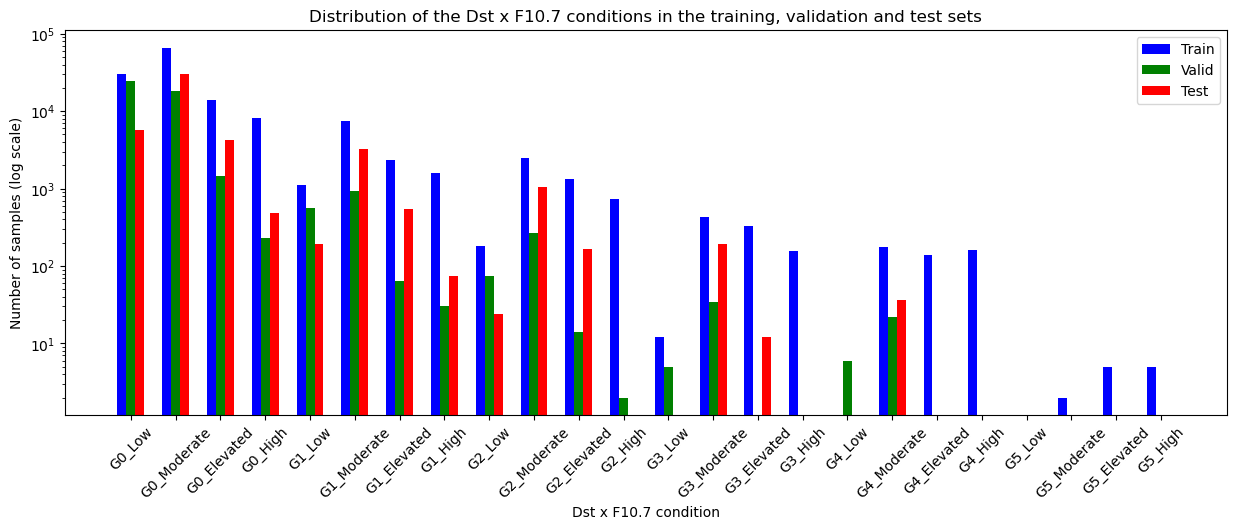

In [18]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the Dst x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_possible_dst_conditions))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_possible_dst_conditions)),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_possible_dst_conditions))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_possible_dst_conditions)))
ax.set_xticklabels(all_possible_dst_conditions, rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('Dst x F10.7 condition')
ax.set_title('Distribution of the Dst x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

In [19]:
# Split y_test and y_test_preds with the idxs from y_test_split_idxs
y_test_split = {}
y_test_preds_split = {}
for key, value in y_test_split_idxs.items():
    y_test_split[key] = y_test[value]
    y_test_preds_split[key] = y_test_preds[value]

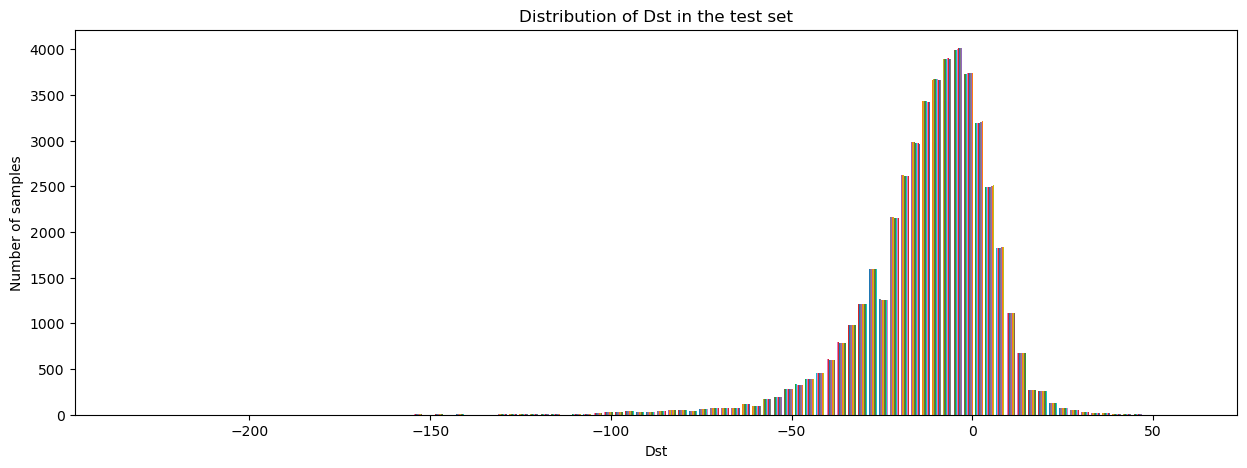

In [20]:
# Plot the distribution of y_test
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(y_test[:, 0, :], bins=100)
ax.set_xlabel('Dst')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of Dst in the test set')
plt.show()


In [21]:
# Create a dataframe with the mean forecast error for the Dst in each 
# Dst x F10.7 condition and each horizon. The horizon is given in days in the
# dataframe, but the actual horizon in the data is given in hours
data = []
for condition in all_possible_dst_conditions:
    if y_test_split.get(condition) is not None and \
    y_test_split.get(condition).shape[0] > 0:
        # Apply forecast_error to every horizon (1..horizon)
        fe_sfu = np.array([forecast_error(y_test_split[condition][:, 0, :],
                                        y_test_preds_split[condition][:, 0, :], 
                                        h) for h in range(1, horizon+1)]).astype(np.float64)
        fe_percent = np.array([percent_forecast_error(y_test_split[condition][:, 0, :],
                                                    y_test_preds_split[condition][:, 0, :], 
                                                    h) for h in range(1, horizon+1)]).astype(np.float64)
        # Aggregate the forecast every 24 hours (get mean and std)
        # TODO: This code breaks if the max horizon is not a multiple of 24
        fe_nT_mean = np.array([np.mean(fe_sfu[i:i+24]) for i in range(0, horizon, 24)])
        fe_nT_std = np.array([np.std(fe_sfu[i:i+24]) for i in range(0, horizon, 24)])
        #fe_percent_mean = np.array([np.mean(fe_percent[i:i+24]) for i in range(0, horizon, 24)])
        #fe_percent_std = np.array([np.std(fe_percent[i:i+24]) for i in range(0, horizon, 24)])
        # additional columns
        h_days = np.arange(1, (horizon // 24) + 1)
        n_samples = y_test_split[condition].shape[0]
        # Append the data to the list
        for h_day, mean, std in zip(h_days, fe_nT_mean, fe_nT_std):
            data.append((condition, h_day, mean, std, n_samples))
# Create the dataframe        
df_results = pd.DataFrame(data, columns=['condition', 'horizon_days', 
                                         'fe_nT_mean', 'fe_nT_std', 'n_samples'])
df_results.head(10)

,condition,horizon_days,fe_nT_mean,fe_nT_std,n_samples
0,G0_Low,1,-1.730014,11.588188,5667
1,G0_Low,2,-2.694987,16.161862,5667
2,G0_Low,3,-2.761682,17.567993,5667
3,G0_Low,4,-2.585800,18.436471,5667
4,G0_Low,5,-2.516124,18.862474,5667
5,G0_Low,6,-2.300429,19.447517,5667
6,G0_Moderate,1,-1.449069,15.055994,29957
7,G0_Moderate,2,-1.492789,21.055045,29957
8,G0_Moderate,3,-1.046986,22.594128,29957
9,G0_Moderate,4,-0.608597,23.046199,29957


In [22]:
# compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_paper = pd.read_csv('../data/benchmark_results_dst.csv', comment = '#')
df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']
# Rename mu with fe_nT_mean and sigma with fe_nT_std in the statistics column
df_results_paper['statistic'] = df_results_paper['statistic'].replace({
    'mu': 'fe_nT_mean', 
    'sigma': 'fe_nT_std'
    })
df_results_paper.head()


,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
0,G0_Low,fe_nT_mean,1.1077,1.1851,1.8191,1.9479,4.7670,4.9067
1,G0_Low,fe_nT_std,14.6264,15.3676,16.0768,16.6027,15.2969,15.5632
3,G0_Moderate,fe_nT_mean,8.8130,9.1455,9.5665,9.8593,10.1396,10.2912
4,G0_Moderate,fe_nT_std,18.2244,18.3000,18.9761,19.0591,19.2045,19.1569
6,G0_Elevated,fe_nT_mean,9.6871,8.8767,8.0980,8.0500,8.9239,9.4235


In [23]:
# Convert the dfs with results into long format
df_results_long = pd.melt(df_results, id_vars=['condition', 'horizon_days'],
                            value_vars=['fe_nT_mean', 'fe_nT_std'],
                            var_name='statistic', value_name='value')
df_results_long.head()

,condition,horizon_days,statistic,value
0,G0_Low,1,fe_nT_mean,-1.730014
1,G0_Low,2,fe_nT_mean,-2.694987
2,G0_Low,3,fe_nT_mean,-2.761682
3,G0_Low,4,fe_nT_mean,-2.585800
4,G0_Low,5,fe_nT_mean,-2.516124


In [24]:
df_results_paper_long = df_results_paper.melt(id_vars=['condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon_days+1)],
                                            var_name='horizon_days', value_name='value')
df_results_paper_long['horizon_days'] = df_results_paper_long['horizon_days'].str.replace(
    ' Days', '').astype(int)
df_results_paper_long.head()

,condition,statistic,horizon_days,value
0,G0_Low,fe_nT_mean,1,1.1077
1,G0_Low,fe_nT_std,1,14.6264
2,G0_Moderate,fe_nT_mean,1,8.8130
3,G0_Moderate,fe_nT_std,1,18.2244
4,G0_Elevated,fe_nT_mean,1,9.6871


In [25]:
# Join the two dataframes (paper and ours) into one, merging on the condition and
# statistic. Right merge (paper)
df_results_merged = pd.merge(df_results_long, df_results_paper_long,
                            on=['condition', 'statistic', 'horizon_days'], how='right',
                            suffixes=('_ours', '_benchmark'))

df_results_merged.head()

,condition,horizon_days,statistic,value_ours,value_benchmark
0,G0_Low,1,fe_nT_mean,-1.730014,1.1077
1,G0_Low,1,fe_nT_std,11.588188,14.6264
2,G0_Moderate,1,fe_nT_mean,-1.449069,8.8130
3,G0_Moderate,1,fe_nT_std,15.055994,18.2244
4,G0_Elevated,1,fe_nT_mean,-1.578116,9.6871


In [26]:
# Bold the best values between ours and the benchmark
bolded_ours, bolded_benchmark = bold_best(
    df_results_merged['value_ours'].round(2),
    df_results_merged['value_benchmark'].round(2),
    higher_better=False, 
    bold_ref_too=True
)
df_results_merged['value_ours'] = bolded_ours
df_results_merged['value_benchmark'] = bolded_benchmark
df_results_merged.head()

,condition,horizon_days,statistic,value_ours,value_benchmark
0,G0_Low,1,fe_nT_mean,\textbf{-1.73},1.11
1,G0_Low,1,fe_nT_std,\textbf{11.59},14.63
2,G0_Moderate,1,fe_nT_mean,\textbf{-1.45},8.81
3,G0_Moderate,1,fe_nT_std,\textbf{15.06},18.22
4,G0_Elevated,1,fe_nT_mean,\textbf{-1.58},9.69


In [27]:
df_print = df_results_merged.pivot_table(index=['condition', 'horizon_days'],
                                    columns='statistic',
                                    values=['value_ours', 'value_benchmark'],
                                    aggfunc=lambda x: x)

df_print.loc[:, ('value_ours', 'fe_nT_mean ± fe_nT_std')] = \
    df_print['value_ours']['fe_nT_mean'] + ' ± ' + df_print['value_ours']['fe_nT_std']
df_print.loc[:, ('value_benchmark', 'fe_nT_mean ± fe_nT_std')] = \
    df_print['value_benchmark']['fe_nT_mean'] + ' ± ' + df_print['value_benchmark']['fe_nT_std']
df_print = df_print.drop(columns=[('value_ours', 'fe_nT_mean'), ('value_ours', 'fe_nT_std'),
                                ('value_benchmark', 'fe_nT_mean'), ('value_benchmark', 'fe_nT_std')])


# Drop the level 0 of the columns, and rename the columns
df_print.columns = df_print.columns.droplevel(0)
df_print.columns = ['Ours', 'benchmark']

# Sort the values of the column condition so that the order is the same as in the
# array all_possible_dst_conditions (not all the conditions are present in the 
# dataframe)
df_print = df_print.reset_index()
df_print['condition'] = pd.Categorical(df_print['condition'], 
                                       all_possible_dst_conditions, ordered=True)
df_print = df_print.sort_values('condition')
# Escape the underscore in the condition names
df_print['condition'] = df_print['condition'].str.replace('_', '\_')
# Escape the column names
df_print.columns = df_print.columns.str.replace('_', '\_')

df_print

,condition,horizon\_days,Ours,benchmark
17,G0\_Low,6,\textbf{-2.3} ± 19.45,4.91 ± \textbf{15.56}
16,G0\_Low,5,\textbf{-2.52} ± 18.86,4.77 ± \textbf{15.3}
15,G0\_Low,4,\textbf{-2.59} ± 18.44,1.95 ± \textbf{16.6}
14,G0\_Low,3,\textbf{-2.76} ± 17.57,1.82 ± \textbf{16.08}
13,G0\_Low,2,\textbf{-2.69} ± 16.16,1.19 ± \textbf{15.37}
12,G0\_Low,1,\textbf{-1.73} ± \textbf{11.59},1.11 ± 14.63
23,G0\_Moderate,6,\textbf{-0.51} ± 22.17,10.29 ± \textbf{19.16}
22,G0\_Moderate,5,\textbf{-0.51} ± 22.51,10.14 ± \textbf{19.2}
21,G0\_Moderate,4,\textbf{-0.61} ± 23.05,9.86 ± \textbf{19.06}
20,G0\_Moderate,3,\textbf{-1.05} ± 22.59,9.57 ± \textbf{18.98}


In [28]:
# Print as a Latex table
print(df_print.to_latex(index=False, escape=False, column_format='lccc', 
                        label='tab:dst_results', caption='Results for the DST task.'))

\begin{table}
\centering
\caption{Results for the DST task.}
\label{tab:dst_results}
\begin{tabular}{lccc}
\toprule
   condition &  horizon\_days &                            Ours &                        benchmark \\
\midrule
     G0\_Low &              6 &           \textbf{-2.3} ± 19.45 &            4.91 ± \textbf{15.56} \\
     G0\_Low &              5 &          \textbf{-2.52} ± 18.86 &             4.77 ± \textbf{15.3} \\
     G0\_Low &              4 &          \textbf{-2.59} ± 18.44 &             1.95 ± \textbf{16.6} \\
     G0\_Low &              3 &          \textbf{-2.76} ± 17.57 &            1.82 ± \textbf{16.08} \\
     G0\_Low &              2 &          \textbf{-2.69} ± 16.16 &            1.19 ± \textbf{15.37} \\
     G0\_Low &              1 & \textbf{-1.73} ± \textbf{11.59} &                     1.11 ± 14.63 \\
G0\_Moderate &              6 &          \textbf{-0.51} ± 22.17 &           10.29 ± \textbf{19.16} \\
G0\_Moderate &              5 &          \textbf{-0.51} ± 2